In [15]:
import pandas as pd
import numpy as np
import os
import datetime

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras.utils import to_categorical

import matplotlib.pyplot as plt
from skimage import color, exposure

from sklearn.metrics import accuracy_score

%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [2]:
cd '/content/drive/My Drive/Colab Notebooks/dw_matrix/matrix_three/dw_matrix_road_sign'

/content/drive/My Drive/Colab Notebooks/dw_matrix/matrix_three/dw_matrix_road_sign


In [0]:
train = pd.read_pickle('data/train.p')
test = pd.read_pickle('data/test.p')

X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

In [0]:
if y_train.ndim==1: y_train = to_categorical(y_train)
if y_test.ndim==1: y_test = to_categorical(y_test)

In [0]:
input_shape = X_train.shape[1:]
num_classes = y_train.shape[1]

In [0]:
def get_cnn_v1(input_shape, num_classes):
  return Sequential([
    Conv2D(filters=64, kernel_size=(3,3), activation='relu', input_shape=input_shape),

    Flatten(),
    Dense(num_classes, activation='softmax')                    
  ])

def train_model(model, X_train, y_train, params_fit={}):
  model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='Adam')

  logdir = os.path.join('logs', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

  model.fit(
      X_train, 
      y_train,
      batch_size=params_fit.get('batch_size', 128),
      epochs=params_fit.get('epochs', 5),
      verbose=params_fit.get('verbose', 1),
      validation_data=params_fit.get('validation_data', (X_train, y_train)),
      callbacks=[tensorboard_callback]
      )
  
  return model

In [24]:
model = get_cnn_v1(input_shape, num_classes)
model_trained = train_model(model, X_train, y_train)

Epoch 1/5
272/272 [==============================] - 3s 11ms/step - loss: 27.1229 - accuracy: 0.7593 - val_loss: 0.2771 - val_accuracy: 0.9382
Epoch 2/5
272/272 [==============================] - 3s 10ms/step - loss: 0.2085 - accuracy: 0.9527 - val_loss: 0.0965 - val_accuracy: 0.9771
Epoch 3/5
272/272 [==============================] - 3s 10ms/step - loss: 0.1347 - accuracy: 0.9694 - val_loss: 0.0665 - val_accuracy: 0.9831
Epoch 4/5
272/272 [==============================] - 3s 11ms/step - loss: 0.1197 - accuracy: 0.9742 - val_loss: 0.1617 - val_accuracy: 0.9652
Epoch 5/5
272/272 [==============================] - 3s 11ms/step - loss: 0.1371 - accuracy: 0.9686 - val_loss: 0.1032 - val_accuracy: 0.9763


In [0]:
df = pd.read_csv('data/signnames.csv')
labels_dict = df.to_dict()['b']

In [0]:
def predict(model_trained, X_test, y_test, scoring=accuracy_score):
  y_test_norm = np.argmax(y_test, axis=1)

  y_pred_prob = model_trained.predict(X_test)
  y_pred = np.argmax(y_pred_prob, axis=1)

  return scoring(y_test_norm, y_pred)

In [25]:
labels_dict[np.argmax(y_pred_prob[400])]

'Wild animals crossing'

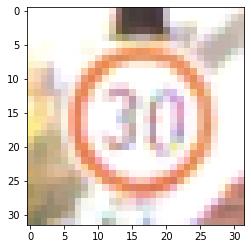

In [26]:
plt.imshow(X_test[400])

In [27]:
predict(model_trained, X_test, y_test)

0.807936507936508

In [0]:
def get_cnn_v2(input_shape, num_classes):
  return Sequential([
    Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=input_shape),
    MaxPool2D(),
    Dropout(0.3),
    Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    MaxPool2D(),
    Dropout(0.3),

    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(0.3),

    Dense(num_classes, activation='softmax')                    
  ])

def train_and_predict(model):
  model_trained = train_model(model, X_train, y_train)

  return predict(model_trained, X_test, y_test)

In [30]:
train_and_predict(get_cnn_v2(input_shape, num_classes))

Epoch 1/5
272/272 [==============================] - 3s 11ms/step - loss: 6.3905 - accuracy: 0.2363 - val_loss: 1.9897 - val_accuracy: 0.4659
Epoch 2/5
272/272 [==============================] - 3s 11ms/step - loss: 1.5519 - accuracy: 0.5420 - val_loss: 0.6705 - val_accuracy: 0.8373
Epoch 3/5
272/272 [==============================] - 3s 10ms/step - loss: 0.7857 - accuracy: 0.7597 - val_loss: 0.2435 - val_accuracy: 0.9499
Epoch 4/5
272/272 [==============================] - 3s 10ms/step - loss: 0.4603 - accuracy: 0.8603 - val_loss: 0.1399 - val_accuracy: 0.9653
Epoch 5/5
272/272 [==============================] - 3s 10ms/step - loss: 0.3308 - accuracy: 0.8994 - val_loss: 0.0703 - val_accuracy: 0.9852


0.9102040816326531

In [0]:
def get_cnn_v3(input_shape, num_classes):
  return Sequential([
    Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=input_shape),
    Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    MaxPool2D(),
    Dropout(0.3),
    Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    MaxPool2D(),
    Dropout(0.3),

    Flatten(),
    
    Dense(1024, activation='relu'),
    Dropout(0.3),

    Dense(num_classes, activation='softmax')                    
  ])

In [32]:
train_and_predict(get_cnn_v3(input_shape, num_classes))

Epoch 1/5
272/272 [==============================] - 4s 14ms/step - loss: 2.7091 - accuracy: 0.4247 - val_loss: 0.5550 - val_accuracy: 0.8784
Epoch 2/5
272/272 [==============================] - 4s 13ms/step - loss: 0.5827 - accuracy: 0.8280 - val_loss: 0.1410 - val_accuracy: 0.9703
Epoch 3/5
272/272 [==============================] - 4s 13ms/step - loss: 0.2900 - accuracy: 0.9161 - val_loss: 0.0629 - val_accuracy: 0.9843
Epoch 4/5
272/272 [==============================] - 3s 13ms/step - loss: 0.1926 - accuracy: 0.9415 - val_loss: 0.0307 - val_accuracy: 0.9934
Epoch 5/5
272/272 [==============================] - 4s 13ms/step - loss: 0.1349 - accuracy: 0.9599 - val_loss: 0.0230 - val_accuracy: 0.9947


0.9678004535147392

In [0]:
def get_cnn_v4(input_shape, num_classes):
  return Sequential([
    Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=input_shape),
    Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same'),
    MaxPool2D(),
    Dropout(0.3),
    Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'),
    Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    MaxPool2D(),
    Dropout(0.3),
    Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'),
    Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    MaxPool2D(),
    Dropout(0.3),

    Flatten(),
    
    Dense(1024, activation='relu'),
    Dropout(0.3),

    Dense(num_classes, activation='softmax')                    
  ])

In [35]:
train_and_predict(get_cnn_v4(input_shape, num_classes))

Epoch 1/5
272/272 [==============================] - 4s 16ms/step - loss: 2.5446 - accuracy: 0.3295 - val_loss: 0.7713 - val_accuracy: 0.7806
Epoch 2/5
272/272 [==============================] - 4s 14ms/step - loss: 0.6809 - accuracy: 0.7895 - val_loss: 0.1599 - val_accuracy: 0.9630
Epoch 3/5
272/272 [==============================] - 4s 14ms/step - loss: 0.3306 - accuracy: 0.9014 - val_loss: 0.0851 - val_accuracy: 0.9780
Epoch 4/5
272/272 [==============================] - 4s 14ms/step - loss: 0.2144 - accuracy: 0.9356 - val_loss: 0.0507 - val_accuracy: 0.9866
Epoch 5/5
272/272 [==============================] - 4s 14ms/step - loss: 0.1585 - accuracy: 0.9543 - val_loss: 0.0289 - val_accuracy: 0.9928


0.9748299319727891

In [0]:
def get_cnn_v5(input_shape, num_classes):
  return Sequential([
    Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=input_shape),
    Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same'),
    MaxPool2D(),
    Dropout(0.3),
    Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'),
    Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    MaxPool2D(),
    Dropout(0.3),
    Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'),
    Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    MaxPool2D(),
    Dropout(0.3),

    Flatten(),
    
    Dense(1024, activation='relu'),
    Dropout(0.3),
    Dense(1024, activation='relu'),
    Dropout(0.3),

    Dense(num_classes, activation='softmax')                    
  ])

In [38]:
train_and_predict(get_cnn_v5(input_shape, num_classes))

Epoch 1/5
272/272 [==============================] - 4s 16ms/step - loss: 2.7014 - accuracy: 0.2726 - val_loss: 1.1897 - val_accuracy: 0.6151
Epoch 2/5
272/272 [==============================] - 4s 15ms/step - loss: 1.1043 - accuracy: 0.6434 - val_loss: 0.3349 - val_accuracy: 0.9017
Epoch 3/5
272/272 [==============================] - 4s 15ms/step - loss: 0.5107 - accuracy: 0.8383 - val_loss: 0.1285 - val_accuracy: 0.9617
Epoch 4/5
272/272 [==============================] - 4s 15ms/step - loss: 0.3189 - accuracy: 0.9021 - val_loss: 0.0700 - val_accuracy: 0.9781
Epoch 5/5
272/272 [==============================] - 4s 15ms/step - loss: 0.2357 - accuracy: 0.9286 - val_loss: 0.0477 - val_accuracy: 0.9863


0.9607709750566893

In [0]:
X_train_gray = color.rgb2gray(X_train).reshape(-1, 32, 32, 1)
X_test_gray = color.rgb2gray(X_test).reshape(-1, 32, 32, 1)

input_shape_gray = X_train_gray.shape[1:]

In [50]:
model = get_cnn_v3(input_shape_gray, num_classes)
model_trained = train_model(model, X_train_gray, y_train, params_fit={'epochs':7})
predict(model_trained, X_test_gray, y_test)

Epoch 1/7
272/272 [==============================] - 4s 14ms/step - loss: 1.2791 - accuracy: 0.6492 - val_loss: 0.1561 - val_accuracy: 0.9657
Epoch 2/7
272/272 [==============================] - 3s 13ms/step - loss: 0.1768 - accuracy: 0.9488 - val_loss: 0.0440 - val_accuracy: 0.9896
Epoch 3/7
272/272 [==============================] - 3s 13ms/step - loss: 0.0965 - accuracy: 0.9713 - val_loss: 0.0211 - val_accuracy: 0.9958
Epoch 4/7
272/272 [==============================] - 3s 13ms/step - loss: 0.0634 - accuracy: 0.9801 - val_loss: 0.0192 - val_accuracy: 0.9955
Epoch 5/7
272/272 [==============================] - 3s 13ms/step - loss: 0.0504 - accuracy: 0.9850 - val_loss: 0.0065 - val_accuracy: 0.9986
Epoch 6/7
272/272 [==============================] - 4s 13ms/step - loss: 0.0413 - accuracy: 0.9877 - val_loss: 0.0057 - val_accuracy: 0.9991
Epoch 7/7
272/272 [==============================] - 3s 13ms/step - loss: 0.0324 - accuracy: 0.9896 - val_loss: 0.0029 - val_accuracy: 0.9997


0.9736961451247166

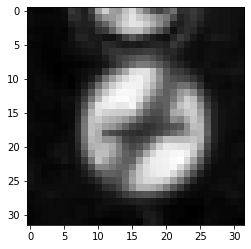

In [45]:
plt.imshow( color.rgb2gray(X_train[0]), cmap=plt.get_cmap('gray') )